# Toy study: Gaussian on a circle

## Setup

In [ ]:
import sys
from collections import OrderedDict
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")
from manifold_flow import transforms, utils, distributions, training
from manifold_flow.flows import Flow, ManifoldFlow
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils.models import create_vector_transform

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [11]:
epochs = 12
n_train = 100000
epsilon = 0.01
train = True

### Data

In [12]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x_sim = simulator.sample(n_train)
x_sim_tensor = torch.from_numpy(x_sim)
train_dataset = TensorDataset(x_sim_tensor, x_sim_tensor)

../../experiments/simulators/spherical_simulator.py:105: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


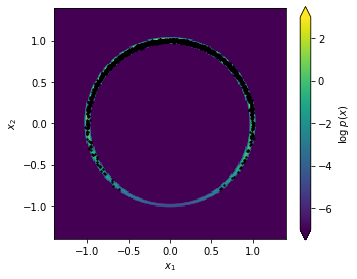

In [13]:
res = 200
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_sim[::50,0], x_sim[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("../figures/simulator_toy.pdf", dpi=500)

In [14]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

print("Integral over density =", np.sum(np.exp(logp_grid) * pixel_size))

Integral over density = 1.0000930850098504


## Set up models

In [ ]:
labels = OrderedDict()
labels["truth"] = "Truth"
labels["sf"] = "Standard flow"
labels["pie"] = "PIE (manifold)"
labels["pie_full"] = "PIE (all)"
labels["mf"] = "MF"
labels["mlfl"] = "MLF-L"
labels["mlfa"] = "MLF-A"
labels["mlflot"] = "MLF-OT"


### Standard flow

In [ ]:
transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
sf = Flow(
    data_dim=2,
    transform=transform
)

In [ ]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(sf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf.state_dict(), "../data/models/flow_1_spherical_gaussian_1_2_0.010.pt")
else:
    sf.load_state_dict(torch.load("../data/models/flow_1_spherical_gaussian_1_2_0.010.pt"))

### Manifold flow (with specified manifold)

In [ ]:
outer_transform=transforms.SphericalCoordinates(n=1, r0=1.)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [ ]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(mf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"mf"}
    )
    torch.save(mf.state_dict(), "../data/models/smf_1_spherical_gaussian_1_2_0.010.pt")
else:
    mf.load_state_dict(torch.load("../data/models/smf_1_spherical_gaussian_1_2_0.010.pt"))

### PIE

In [ ]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

In [ ]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(pie)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"pie"}
    )
    torch.save(pie.state_dict(), "../data/models/pie_1_spherical_gaussian_1_2_0.010.pt")
else:
    pie.load_state_dict(torch.load("../data/models/pie_1_spherical_gaussian_1_2_0.010.pt"))

### MLF-L

In [18]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mlfl = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [ ]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(mlfl)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs // 3,
        forward_kwargs={"mode":"projection"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[100., 0.1],
        epochs=epochs // 3,
        forward_kwargs={"mode":"mf"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[0., 1.],
        epochs=epochs // 3,
        parameters=mf.inner_transform.parameters(),
        forward_kwargs={"mode":"mf"}
    )
    torch.save(mlfl.state_dict(), "../data/models/mf_1_spherical_gaussian_1_2_0.010.pt")
else:
    mlfl.load_state_dict(torch.load("../data/models/mf_1_spherical_gaussian_1_2_0.010.pt"))

09:59 manifold_flow.training.trainer INFO    Training on CPU with single precision
09:59 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.95903 (mse:  0.020)
09:59 manifold_flow.training.trainer INFO               val. loss   0.84694 (mse:  0.008)
09:59 manifold_flow.training.trainer INFO    Epoch   2: train loss  1.59196 (mse:  0.016)
09:59 manifold_flow.training.trainer INFO               val. loss   5.25209 (mse:  0.053)
09:59 manifold_flow.training.trainer INFO    Epoch   3: train loss  1.38163 (mse:  0.014)
09:59 manifold_flow.training.trainer INFO               val. loss   0.95339 (mse:  0.010)
09:59 manifold_flow.training.trainer INFO    Epoch   4: train loss  1.03006 (mse:  0.010)
09:59 manifold_flow.training.trainer INFO               val. loss   1.22381 (mse:  0.012)
09:59 manifold_flow.training.trainer INFO    Early stopping after epoch 1, with loss  0.84694 compared to final loss  1.22381
10:07 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.6

### MLF-A

In [ ]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mlfa = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [ ]:
if train:
    trainer = ManifoldFlowTrainer(mlfa)
    metatrainer = AlternatingTrainer(mlfa, trainer, trainer)
    metatrainer.train(
        train_dataset,
        loss_functions=[training.losses.mse, training.losses.nll],
        loss_function_trainers=[0, 1],
        loss_labels=["MSE", "NLL"],
        loss_weights=[100., 0.1],
        epochs=args.epochs,
        parameters=[model.parameters(), model.inner_transform.parameters()],
        trainer_kwargs=[{"forward_kwargs": {"mode": "projection"}}, {"forward_kwargs": {"mode": "pie"}}],
    )
    torch.save(mlfa.state_dict(), "../data/models/mf_1_spherical_gaussian_1_2_0.010_alternate.pt")
else:
    mlfa.load_state_dict(torch.load("../data/models/mf_1_spherical_gaussian_1_2_0.010_alternate.pt"))

### MLF-OT

In [ ]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mlfot = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [ ]:
if train:
    trainer = training.trainer.GenerativeTrainer(mlfot)
    trainer.train(
        train_dataset,
        [training.losses.make_sinkhorn_divergence()],
        loss_weights=[100.],
        epochs=epochs,
        batch_size=1000,
    )
    torch.save(mlfot.state_dict(), "../data/models/gamf_1_spherical_gaussian_1_2_0.010.pt")
else:
    mlfot.load_state_dict(torch.load("../data/models/gamf_1_spherical_gaussian_1_2_0.010.pt"))

## Evaluate the models

### Sample from models

In [ ]:
x_gen = OrderedDict()

x_gen["sf"] = sf.sample(n=1000).detach().numpy()
x_gen["mf"] = mf.sample(n=1000).detach().numpy()
x_gen["pie"] = pie.sample(n=1000).detach().numpy()
x_gen["pie_full"] = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()
x_gen["mlfl"] = mlfl.sample(n=1000).detach().numpy()
x_gen["mlfa"] = mlfa.sample(n=1000).detach().numpy()
x_gen["mlfot"] = mlfot.sample(n=1000).detach().numpy()

### Calculate metrics for generated samples: mean distance from manifold, true likelihood

In [ ]:
def generative_metrics(x, logp_min=-100., d_max=1., summary_fn=np.mean):
    logp_gen = simulator.log_density(x)
    logp_gen[(~np.isfinite(logp_gen)) + (logp_gen<logp_min)] = logp_min
    logp_summary = summary_fn(logp_gen)
    
    d_gen = np.abs(np.sum(x**2, axis=1)**0.5 - 1)
    d_gen[(~np.isfinite(d_gen)) + (d_gen>d_max)] = d_max
    d_summary = summary_fn(d_gen)
    
    return logp_summary, d_summary


logp_gen, d_gen = OrderedDict(), OrderedDict()

for key, val in x_gen.items():
    logp_gen[key], d_gen[key] = generative_metrics(x_gen[key])
    

print("Mean true log likelihood of samples generated from flows (higher is better):")
for key, val in logp_gen.items():
    print "  {:>10.10s}: {:>6.1f}".format(key, val)
    
print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
for key, val in d_gen.items():
    print "  {:>10.10s}: {:>6.4f}".format(key, val)
    

### Evaluate model likelihood over data space

In [ ]:
res = 200
boundary = 1.5

x_range = np.linspace(-boundary, boundary, res)
x_range = np.linspace(-boundary, boundary, res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)


logp_grid = OrderedDict()
logp_grid["truth"] = simulator.log_density(x_grid).reshape((res, res))
logp_grid["truth"][~np.isfinite(logp_grid["truth"])] = -1000000.
logp_grid["sf"] = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
logp_grid["pie_full"] = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))


In [ ]:
def likelihood_along_manifold(model, mode="mf", zmin=-5., zmax=5., n_samples=100, epsilon=0.02):
    # Sample
    u = torch.linspace(zmin, zmax, n_samples).view(-1,1)
    x = model.sample(n=n_samples, u=u).detach().numpy()
    
    # Interpolate
    x_interpol = [x[0]]
    for x, x_prev in zip(x[:-1], x[1:]):
        distance = np.linalg.norm(x-x_prev)
        if distance > epsilon:
            n_insert = int(distance / epsilon)
            for frac in np.linspace(0., 1., n_insert + 2)[1:-1]:
                x_interpol.append(x_prev + frac * (x-x_prev))
        x_interpol.append(x)
    x_interpol.append(x)
    x_interpol = np.array(x_interpol)

    # Evaluate likelihood
    log_probs = model.log_prob(torch.FloatTensor(x_interpol), mode=mode).detach().numpy()

    # Return
    return x_interpol, log_probs


logp_manifold, x_manifold = OrderedDict(), OrderedDict()
x_manifold["mf", logp_manifold["mf"] = likelihood_along_manifold(mf)
x_manifold["mlfl", logp_manifold["mlfl"] = likelihood_along_manifold(mlfl)
x_manifold["mlfa", logp_manifold["mlfa"] = likelihood_along_manifold(mlfa)
x_manifold["mlfot", logp_manifold["mlfot"] = likelihood_along_manifold(mlfot)


### Plot likelihoods

In [ ]:
fig = plt.figure(figsize=(15,8))
show = ["truth", "sf", "pie", "mf", "mlfa", "mlfot"]

for i, key in enumerate(show):
    ax = plt.subplot(3,2,i+1)
    
    try:
        x = x_manifold[key]
        logp = logp_manifold[key]
        zmin, zmax = np.max(logp) - 5., np.max(logp)
        im = plt.scatter(
            x[:,0], x[:,1],
            c=np.clip(logp, zmin, zmax),
            s=15.,
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
        )

    except:
        logp = logp_grid[key]
        zmin, zmax = np.max(logp) - 5., np.max(logp)
        im = plt.imshow(
            np.clip(logp, zmin, zmax),
            extent=(-1.5, 1.5, -1.5, 1.5),
            origin="lower",
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
            interpolation='nearest'
        )
    cb = plt.colorbar(im, extend="both")

    plt.xlim(-boundary, boundary)
    plt.ylim(-boundary, boundary)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(r"{} log likelihood".format(labels[key]))
    
plt.tight_layout()
plt.savefig("../figures/log_likelihood_toy.pdf", dpi=600)


## Other plots (not updated to new conventions yet)

### Visualize generated samples

In [ ]:
# skip = 4
# res = 250
# x_range = np.linspace(-1.5,1.5,res)
# y_range = np.linspace(-1.5,1.5,res)
# xx, yy = np.meshgrid(x_range, y_range)
# x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
# logp_grid = simulator.log_density(x_grid).reshape((res, res))
# logp_grid[~np.isfinite(logp_grid)] = -1000000.
# zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)+ 10.

# fig = plt.figure(figsize=(15,8))

# for i, (label, x) in enumerate(zip(
#     ["Flow (affine coupling)", "Flow (rational-quadratic coupling)", "PIE", "Manifold flow", "Specified MF",  "Generative adversarial MF"],
#     [x_gen_sf, x_gen_sf3, x_gen_pie_full, x_gen_mf, x_gen_smf, x_gen_gamf]
#      )):
#     ax = plt.subplot(2,3,i+1)

#     pcm = plt.imshow(
#         np.clip(logp_grid, zmin, zmax),
#         extent=(-1.5,1.5,-1.5,1.5),
#         origin="lower",
#         cmap="Greys",
#         norm=matplotlib.colors.Normalize(zmin, zmax),
#         interpolation='nearest'
#     )
#     cb = plt.colorbar(pcm, extend="both")
#     plt.scatter(x[::skip,0], x[::skip,1], s=12., c="C3", label=label)

#     plt.legend()

#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
#     plt.xlabel("$x_1$")
#     plt.ylabel("$x_2$")
#     cb.set_label("True log density")

# plt.tight_layout()
# plt.savefig("../figures/spherical_gaussian_2d_generation.pdf")


### Plot reconstruction performance

In [ ]:
# x_in = SphericalGaussianSimulator(1,2,epsilon=10*epsilon).sample(100)
# x_in = torch.FloatTensor(x_in)
# x_out = mf(x_in)[0]
# x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
# dx = x_out - x_in

In [ ]:
# fig = plt.figure(figsize=(5,5))
# ax = plt.gca()
# plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
# plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
# plt.quiver(
#     x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
#     angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
# )

# plt.xlim(-1.5,1.5)
# plt.ylim(-1.5,1.5)
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.tight_layout()

# plt.savefig("../figures/spherical_gaussian_2d_mf_reco.pdf")


### Model anatomy

In [ ]:
# def make_anatomy_plot(model, name, res=25):
#     x_range = np.linspace(-1.5,1.5,res)
#     y_range = np.linspace(-1.5,1.5,res)
#     xx, yy = np.meshgrid(x_range, y_range)
#     x = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
#     x = torch.FloatTensor(x)
#     x.requires_grad = True

#     # Encode
#     u, h_manifold, h_orthogonal, log_det_outer, log_det_inner = model._encode(x)

#     # Decode
#     x_reco, _, _, inv_jacobian_outer = model._decode(u, mode="mf")
#     _, inv_log_det_inner, inv_log_det_outer, _ = model._decode(u, mode="slice")

#     # inv_jacobian_outer is dx / du, but still need to restrict this to the manifold latents
#     inv_jacobian_outer = inv_jacobian_outer[:, :, : model.latent_dim]
#     # And finally calculate log det (J^T J)
#     jtj = torch.bmm(torch.transpose(inv_jacobian_outer, -2, -1), inv_jacobian_outer)
#     mf_log_det_outer = - 0.5 * torch.slogdet(jtj)[1]

#     # Base log prob
#     log_prob_latent = model.manifold_latent_distribution._log_prob(u, context=None)
    
#     # Plot
#     fig = plt.figure(figsize=(12,9))

#     for panel, (label, quantity, diverging) in enumerate(zip(
#         ["Perp latent", "Manifold latent after outer flow", "Manifold latent after inner flow",
#          "log det outer (PIE)", "log det inner", "Base log prob",
#          "log det outer (MF)", "log det outer (Slice of PIE)", "delta log det outer (MF - Slice)"],
#         [h_orthogonal, h_manifold, u,
#          log_det_outer, - log_det_inner, log_prob_latent,
#          mf_log_det_outer, - inv_log_det_outer, mf_log_det_outer + inv_log_det_outer],
#         [True, True, True, False, False, False, False, False, False]
#     )):
#         ax = plt.subplot(3,3,panel+1)

#         quantity_ = quantity.detach().numpy()
#         quantity_ = quantity_.flatten() + np.zeros((res**2))

#         if diverging:
#             zmin, zmax = - 2. * np.std(quantity_), 2. * np.std(quantity_)
#         else:
#             zmin, zmax = np.mean(quantity_) - 1.5 * np.std(quantity_), np.mean(quantity_) + 1.5 * np.std(quantity_)

#         pcm = plt.imshow(
#             np.clip(quantity_, zmin, zmax).reshape(res, res),
#             extent=(-1.5, 1.5, -1.5, 1.5),
#             origin="lower",
#             cmap="PRGn" if diverging else "viridis",
#             norm=matplotlib.colors.Normalize(zmin, zmax),
#             interpolation='nearest'
#         )
#         cb = plt.colorbar(pcm, extend="both")
#         # plt.scatter(x_gen_mf[::10,0], x_gen_mf[::10,1], s=3., c="black")

#         plt.xlim(-1.5,1.5)
#         plt.ylim(-1.5,1.5)
#         plt.xlabel("$x_1$")
#         plt.ylabel("$x_2$")
#         cb.set_label(label)
#         plt.tight_layout()

#     plt.savefig("../figures/spherical_gaussian_2d_{}_anatomy.pdf".format(name))